In [1]:
%load_ext ipydex.displaytools
import glob
import os
import joblib
import numba
import numpy as np
from scipy.constants import g as gravity
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
output_notebook()
from visualisation import Animation, plot_sim_states, plot_sample_distribution_scatter
from sympy.interactive import printing
printing.init_printing()
from auxiliaries import print_state

from systools import Simulator, TrajectoryProblem, PendelWagenSystem, TrainingPlotter
from functions import spline_func_gen
from lmntools import LMNRegressor

from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

pop, algo = np.load('0.5.npy')

Loading BokehJS ...

### Sampleverteilung - Parameterraum

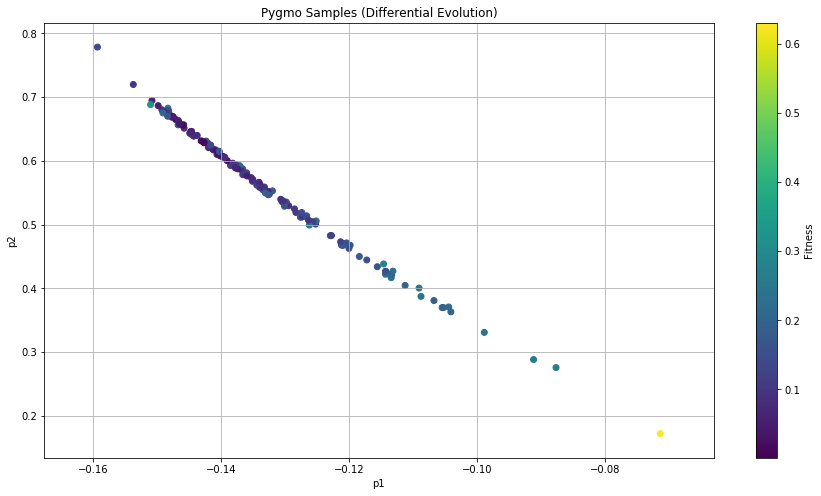

In [2]:
plt.figure(figsize=(15,8))
plt.scatter(*pop.get_x().T, c=pop.get_f()[:,0])
plt.title("Pygmo Samples (Differential Evolution)")
plt.xlabel("p1")
plt.ylabel("p2")
plt.grid()
plt.colorbar(label='Fitness');

### Zielzustände der Samples mittels Simulation ermitteln

In [3]:
# Vorgabe der Wagenposition q
func = spline_func_gen(kind=5, diff=2, bc_type=[[(1, 0), (2, 0)], [(1, 0), (2, 0)]])

parameter_values = dict(g=gravity, m1=1, m2=0.1, l=0.5)
sys = PendelWagenSystem()
model = sys.get_sim_model(parameter_values)

sim = Simulator(model, x0=[0.0, 0.0, 0.0, 0.0], t0=0.0, T=1.0, input_func_gen=func,
                func_parameters={'n': 2, 'start_end': (0.0, 0.5)})

fitness_threshold = 0.5

In [4]:
# Laden bzw. Simulation der tatsächlichen Endzustände
try:
    X = np.load("X.npy")
    print("Loaded")
    
except IOError:
    X = np.zeros((pop.get_x().shape[0], 4))

    for idx, p in enumerate(tqdm_notebook(pop.get_x())):
        res = sim.solve(p, use_sp2c=False)
        X[idx, :] = res[0][-1, :]

    np.save("X.npy", X)

Loaded


In [5]:
F = pop.get_f()
P = pop.get_x()
X_train = X[[F<fitness_threshold][0].ravel()]
y_train = P[[F<fitness_threshold][0].ravel()]

X_train.shape

### Sampleverteilung - Zustandsraum

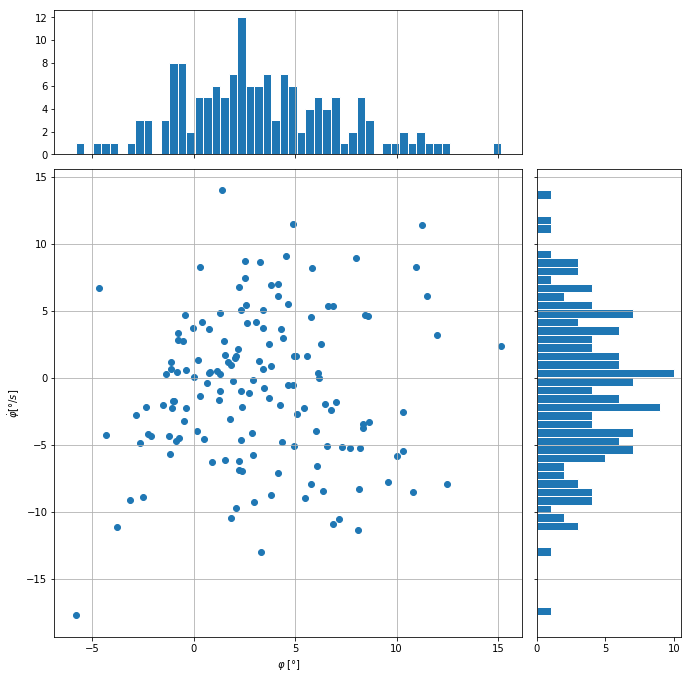

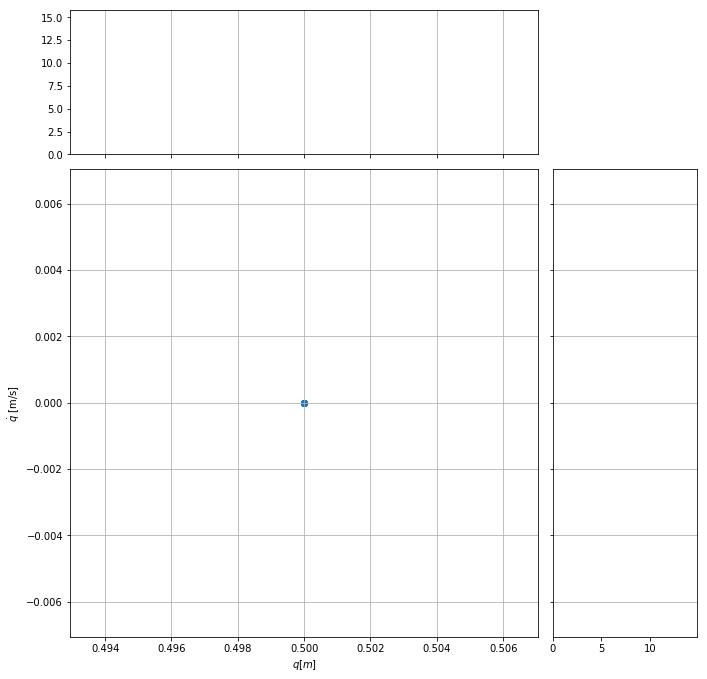

In [6]:
fig1 = plt.figure(figsize=(10, 10))
plot_sample_distribution_scatter(np.rad2deg(X_train[:,[0,2]]), fig=fig1,
                                 labels=[r"$\varphi$ [°]", r"$\dot{\varphi} [°/s]$"])

fig2 = plt.figure(figsize=(10, 10))
plot_sample_distribution_scatter(X_train[:,[1,3]], fig=fig2, labels=[r"$q [m]$", r"$\dot{q}$ [m/s]"])

In [7]:
bounds = np.array(list(zip(np.min(X_train, axis=0).tolist(), np.max(X_train, axis=0).tolist()))).tolist() ##:

cross_validation = True

LMN = []
if cross_validation:
    for i, yt in enumerate(y_train.T):
        print(f"***Training des {i+1}. Modells***")

        param_grid = [
            {'local_models__degree': [1],
             'network__smoothness': [0.1, 0.3, 0.5, 0.7, 0.9],
             'model_complexity': [1, 2, 5, 10, 20, 50]}
        ]

        lmn = LMNRegressor(network='lolimot', training_tol=1e-8, refinement='loser',
                           plotter=None, notebook=True, random_state=42, verbosity=0)

        search = GridSearchCV(estimator=lmn, param_grid=param_grid, cv=5,
                              scoring=make_scorer(mean_squared_error, greater_is_better=False),
                              refit=True, verbose=1, n_jobs=-1, return_train_score=True)

        search.fit(X_train[:, [0, 2]], yt)

        print(f"-> best score {search.best_score_:.2e} with {search.best_params_}")
        LMN.append(search.best_estimator_)

else:
    LMN = [LMNRegressor(network='lolimot', local_models='linear', model_complexity=10, smoothness=0.3,
                        notebook=True, random_state=42, verbosity=1, training_tol=1e-10),
           LMNRegressor(network='lolimot', local_models='linear', model_complexity=50, smoothness=0.7,
                        notebook=True, random_state=42, verbosity=1, training_tol=1e-10)]
    
    for i, yt in enumerate(y_train.T):
        print(f"***Training des {i+1}. Modells***")
        LMN[i].fit(X_train[:, [0, 2]], yt)

---
***Training des 1. Modells***
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.9s finished


-> best score -5.06e-08 with {'local_models__degree': 1, 'model_complexity': 10, 'network__smoothness': 0.3}
***Training des 2. Modells***
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.7s finished


-> best score -2.51e-07 with {'local_models__degree': 1, 'model_complexity': 50, 'network__smoothness': 0.7}


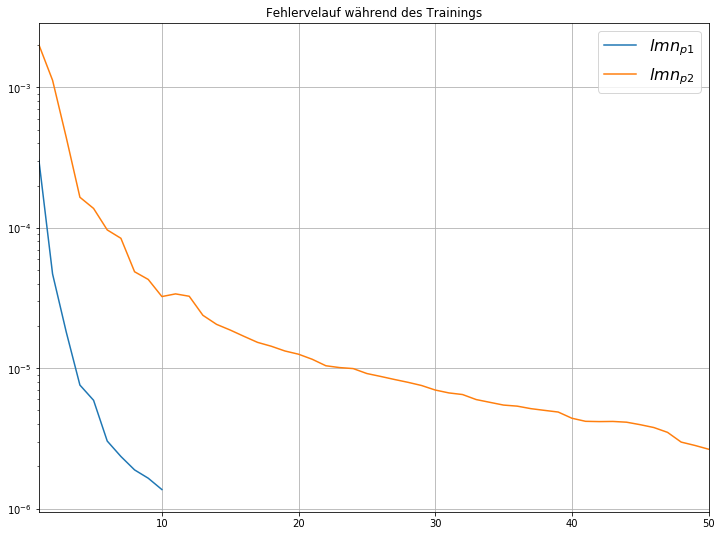

In [8]:
plt.figure(figsize=(12, 9))
for i, lmn in enumerate(LMN):
    if lmn.M == 1:
        continue
    train_line, *_ = plt.semilogy(np.arange(1, lmn.M + 1 , 1), lmn.global_loss, label=r'$lmn_{p' + f'{i+1}' + '}$')

plt.legend(prop={'size': 16})
plt.title("Fehlervelauf während des Trainings")
plt.xlim([1, np.max([lmn.M for lmn in LMN])])
plt.grid();

In [9]:
target_state = [0.1, 0.1]
np.rad2deg(target_state) ##:
param = np.array([lmn.predict([target_state]) for lmn in LMN]).T[0].tolist()

np.rad2deg(target_state)  := array([5.72957795, 5.72957795])

___


φ=5.9868°
q=0.5000005983507382m
φ.=6.8913°/s
q.=5.713450906758029e-08m/s


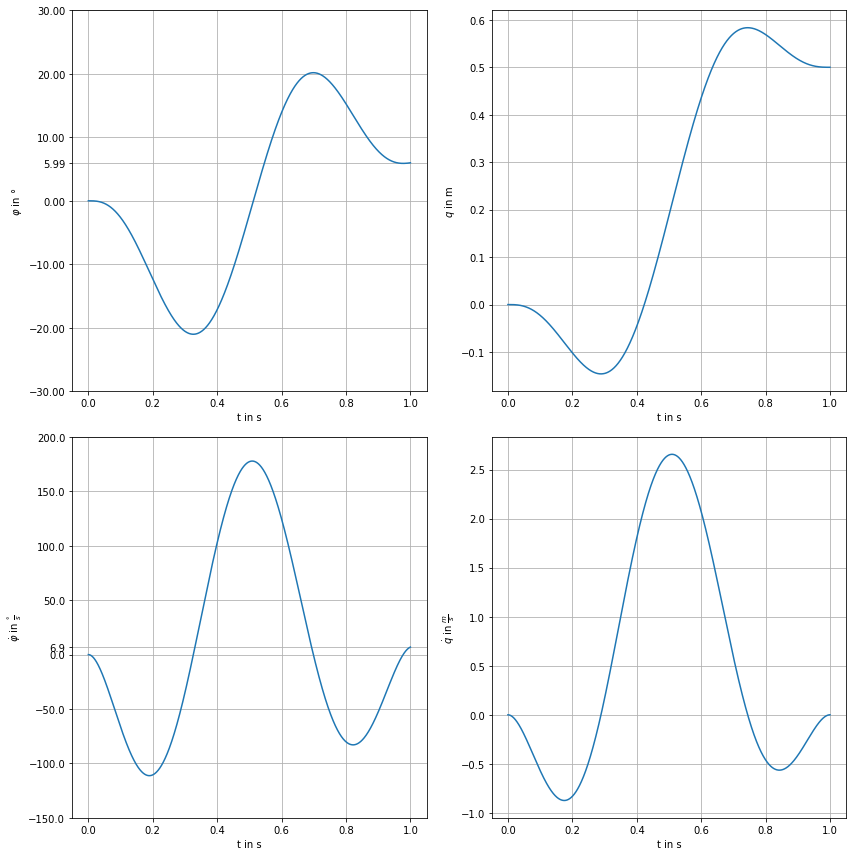

In [10]:
res = sim.solve(param, start_end=(0.0, 0.5), use_sp2c=False)
plot_sim_states(res)
print_state(res[0][-1,:])

In [11]:
from plot import PlotterLLM


### Lolimot-Partitionierung

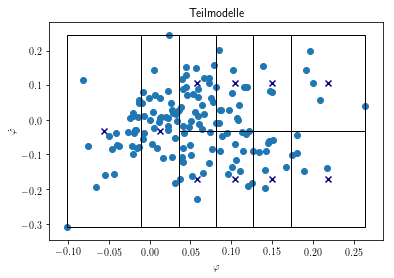

In [12]:
lmn = LMN[0]
plotter = PlotterLLM(['models3D'], False)
plotter.llm = lmn
plotter.sort_idx = range(lmn.C.shape[1])
plotter.models3D(plotter.axes[0])
plt.scatter(*X_train[:,[0,2]].T)
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$\dot{\varphi}$");

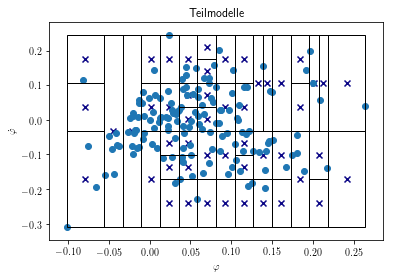

In [13]:
lmn = LMN[1]
plotter = PlotterLLM(['models3D'], False)
plotter.llm = lmn
plotter.sort_idx = range(lmn.C.shape[1])
plotter.models3D(plotter.axes[0])
plt.scatter(*X_train[:,[0,2]].T)
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$\dot{\varphi}$");

### Approximationsgüte

In [14]:
k = 50
phi, phidot = np.meshgrid(np.linspace(*bounds[0], k), np.linspace(*bounds[2], k))
X_test = np.vstack((phi.flatten(), phidot.flatten())).T
P_pred = np.array([lmn.predict(X_test) for lmn in LMN]).T

In [ ]:
# Laden bzw. Simulation der tatsächlichen Endzustände
try:
    X_pred = np.load("X_pred.npy")
    raise IOError
    print("Loaded")
    
except IOError:
    X_pred = np.zeros((X_test.shape[0], 4))

    for idx, p in enumerate(tqdm_notebook(P_pred)):
        res = sim.solve(p)#, use_sp2c=False)
        X_pred[idx, :] = res[0][-1, :]

    np.save("X_pred.npy", X_pred)

In [16]:
X_err = np.sqrt(np.sum((X_test - X_pred[:, [0, 2]])**2, axis=1))

plt.figure(figsize=(12, 12))
plt.imshow(X_err.reshape((k, k)), extent=[*bounds[0], *bounds[2]], aspect='equal', origin='lower')
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$\dot{\varphi}$")
plt.colorbar(label="RMSE");

ValueError: operands could not be broadcast together with shapes (2500,2) (400,2) 